In [1]:
#importing the packages needed
import pandas as pd
import numpy as np
import nltk
import gensim
import gensim.downloader as gensim_api

import re

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

##for word embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


## for machine learning model building and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import sklearn.metrics as metrics



C:\Users\karth\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#loading the train and the test data
train = pd.read_csv("C:/Users/karth/Desktop/Dissertation/Data/AG_news_train.csv")
test = pd.read_csv("C:/Users/karth/Desktop/Dissertation/Data/AG_news_test.csv")
frames = [train,test]
data = pd.concat(frames)
data

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [5]:
#having a look at a sample news description
data.iloc[4,2]

'AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.'

In [6]:
#checking the datatype of the columns
data.dtypes

Class Index     int64
Title          object
Description    object
dtype: object

In [7]:
data['Class Index'] = data['Class Index'].astype('str')
data

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [8]:
classes = {"1" : "World",
                     "2" : "Sports",
                     "3" : "Business",
                     "4" : "Sci&Tech"}

data['Class'] = data['Class Index'].map(classes)
data

,Class Index,Title,Description,Class
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business
...,...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,World
7596,2,Void is filled with Clement,With the supply of attractive pitching options...,Sports
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,Sports
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,Business


In [9]:
#randomly looking at a sample to understand the preprocessing steps needed done
data.iloc[119995,2]

' KARACHI (Reuters) - Pakistani President Pervez Musharraf  has said he will stay on as army chief, reneging on a pledge to  quit the powerful post by the end of the year.'

In [10]:
train_sample = data.groupby('Class').apply(lambda x: x.sample(n=2500)).reset_index(drop = True)
train_sample['Class'].value_counts()

Sci&Tech    2500
Business    2500
World       2500
Sports      2500
Name: Class, dtype: int64

In [11]:
#based on the understanding from the dataset I have built the pre-processing steps needed to be done for the whole data
def text_preprocessing(text, flag_stemm=False, flag_lemma=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flag_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flag_lemma == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

lst_stopwords = nltk.corpus.stopwords.words("english")

In [12]:
##applying the text preprocessing function created to the entire dataset
data["cleaned_text"] = data["Description"].apply(lambda x: text_preprocessing(x, flag_stemm=False, flag_lemma=True, lst_stopwords=lst_stopwords))
data.head()

,Class Index,Title,Description,Class,cleaned_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,reuters shortsellers wall street dwindlingband...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business,reuters private investment firm carlyle groupw...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business,reuters soaring crude price plus worriesabout ...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business,reuters authority halted oil exportflows main ...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business,afp tearaway world oil price toppling record s...


In [13]:
##applying the text preprocessing function created to the entire dataset
train_sample["cleaned_text"] = train_sample["Description"].apply(lambda x: text_preprocessing(x, flag_stemm=False, flag_lemma=True, lst_stopwords=lst_stopwords))
train_sample.head()

,Class Index,Title,Description,Class,cleaned_text
0,3,Merck Rises 1.52 Percent Before Bell,NEW YORK (Reuters) - Shares of drugmaker Merc...,Business,new york reuters share drugmaker merck co inc ...
1,3,Time Warner to settle securities fraud charges,Time Warner Inc. agreed yesterday to pay \$210...,Business,time warner inc agreed yesterday pay 210 milli...
2,3,Black quits top jobs at Hollinger Inc,"CONRAD Black, the former owner of the Daily Te...",Business,conrad black former owner daily telegraph yest...
3,3,"Sprint, Nextel consider lucrative deal",Sprint (FON) and Nextel (NXTL) are in discussi...,Business,sprint fon nextel nxtl discussion merge eye cr...
4,3,"Alltel buys Cingular properties, expands network",Little Rock-based Alltel will expand its wirel...,Business,little rockbased alltel expand wireless phone ...


In [14]:
#printing the cleaned and uncleaned text for reference
data1 = train_sample.head()
data2 = data1[['Class', 'Description', 'cleaned_text']]
pd.set_option("display.max_colwidth", -1)
#data.to_csv("data.csv", sep='\t')
data2

<ipython-input-14-b4d2a191d2af>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,Class,Description,cleaned_text
0,Business,"NEW YORK (Reuters) - Shares of drugmaker Merck Co. Inc. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=MRK.N target=/stocks/quickinfo/fullquote""&gt;MRK.N&lt;/A&gt; traded 1.52 percent higher on volume of more than 61,000 shares in pre-market dealings on Friday, a day after the stock plunged to an eight-year low after the company withdrew its arthritis drug Vioxx.",new york reuters share drugmaker merck co inc lta hrefhttpwwwinvestorreuterscomfullquoteaspxtickermrkn targetstocksquickinfofullquotegtmrknltagt traded 152 percent higher volume 61000 share premarket dealing friday day stock plunged eightyear low company withdrew arthritis drug vioxx
1,Business,Time Warner Inc. agreed yesterday to pay \$210 million to settle criminal securities fraud charges brought by the Justice Department against the company's America Online unit. The media giant also is prepared to pay \$300 million to end another probe by the Securities and Exchange Commission.,time warner inc agreed yesterday pay 210 million settle criminal security fraud charge brought justice department company america online unit medium giant also prepared pay 300 million end another probe security exchange commission
2,Business,"CONRAD Black, the former owner of the Daily Telegraph, yesterday stood down as chairman and chief executive of Hollinger Inc., the Toronto-based holding company which has voting control over newspaper publisher Hollinger International.",conrad black former owner daily telegraph yesterday stood chairman chief executive hollinger inc torontobased holding company voting control newspaper publisher hollinger international
3,Business,"Sprint (FON) and Nextel (NXTL) are in discussions to merge, with an eye to creating a wireless giant that could rival Cingular and Verizon Wireless in size and scope, according to two people with direct knowledge of the talks.",sprint fon nextel nxtl discussion merge eye creating wireless giant could rival cingular verizon wireless size scope according two people direct knowledge talk
4,Business,"Little Rock-based Alltel will expand its wireless phone service in Connecticut, Kentucky, Mississippi, Oklahoma and Texas in a \$170 million deal with Cingular Wireless.",little rockbased alltel expand wireless phone service connecticut kentucky mississippi oklahoma texas 170 million deal cingular wireless


In [15]:
#building a function to plot the classification metrics, confusion matrix and ROC curves for the classifier results
def model_evaluation(y_data, y_predicted,predicted_prob):
    classes = np.unique(y_data)
    y_test_array = pd.get_dummies(y_data, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_data, y_predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")

    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, y_predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

# Using a sample of 1000 in each class to perform grid search and find the optimal parameters then use the whole train dataset to fit the model using the ideal parameters and test the model on the test set

In [16]:
##count vectorizer to convert text to feature vectors
matrix = CountVectorizer(max_features=1000)
X_sample = matrix.fit_transform(train_sample.iloc[:, -1]).toarray()

##storing the class label in y 
y_sample = train_sample.iloc[:, 0].astype(str)

##count vectorizer to convert text to feature vectors
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(data.iloc[:, -1]).toarray()

##storing the class label in y 
y = data.iloc[:, 0].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2021)

Accuracy: 0.84
Auc: 0.96
Detail:
              precision    recall  f1-score   support

           1       0.85      0.86      0.85     10532
           2       0.90      0.94      0.92     10580
           3       0.82      0.79      0.80     10446
           4       0.81      0.78      0.80     10550

    accuracy                           0.84     42108
   macro avg       0.84      0.84      0.84     42108
weighted avg       0.84      0.84      0.84     42108



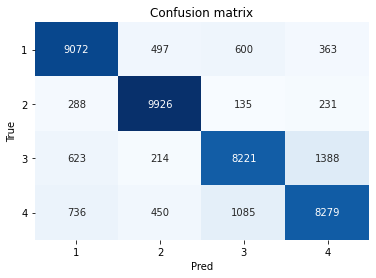

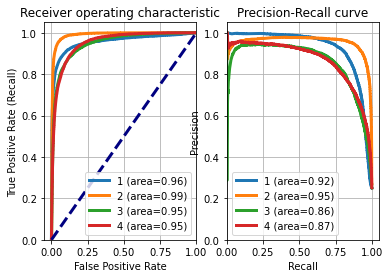

In [17]:
# Naive Bayes 
classifier_NB = MultinomialNB()
classifier_NB.fit(X, y)

predicted_NB = classifier_NB.predict(X_test)
predicted_prob_NB = classifier_NB.predict_proba(X_test)

model_evaluation(y_test,predicted_NB,predicted_prob_NB)

In [15]:
from sklearn.svm import SVC
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sample, y_sample)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.789833 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.469667 (0.026908) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.779500 (0.020355) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.789833 (0.016418) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.298833 (0.040113) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.558500 (0.025639) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.731000 (0.022245) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.251833 (0.002809) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
0.538167 (0.034369) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.641167 (0.024510) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}


C:\Users\karth\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy: 0.86
Auc: 0.96
Detail:
              precision    recall  f1-score   support

           1       0.88      0.85      0.86     10532
           2       0.90      0.95      0.92     10580
           3       0.83      0.81      0.82     10446
           4       0.81      0.82      0.82     10550

    accuracy                           0.86     42108
   macro avg       0.86      0.86      0.85     42108
weighted avg       0.86      0.86      0.86     42108



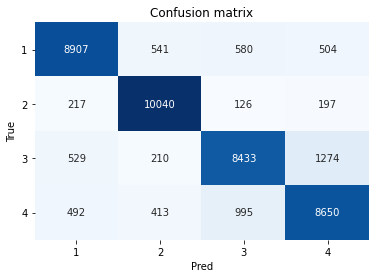

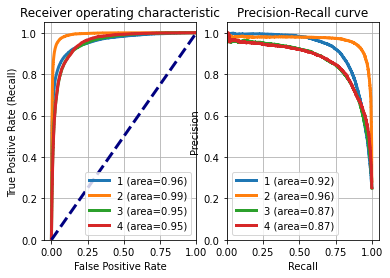

In [17]:
# linear SVC
classifier_SVC = SVC(C= 1.0, gamma= 'scale', kernel= 'sigmoid')
classifier_SVC = LinearSVC(random_state=2021, tol=1e-5)
classifier_SVC.fit(X_train, y_train)

predicted_SVC = classifier_SVC.predict(X_test)
predicted_prob_SVC = classifier_SVC._predict_proba_lr(X_test)

model_evaluation(y_test,predicted_SVC,predicted_prob_SVC)

In [15]:
# example of grid searching key hyperparametres for logistic regression
# define dataset
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sample, y_sample)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.804000 using {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.751333 (0.019767) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.751500 (0.019786) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.755000 (0.020228) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.765500 (0.018308) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.765500 (0.018308) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.772333 (0.017235) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.788500 (0.017861) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.788500 (0.017861) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.796333 (0.018504) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.804000 (0.020571) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.804000 (0.020571) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.803667 (0.020974) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.786167 (0.020694) wit

Accuracy: 0.86
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           1       0.88      0.85      0.86     10532
           2       0.90      0.94      0.92     10580
           3       0.83      0.81      0.82     10446
           4       0.81      0.82      0.82     10550

    accuracy                           0.86     42108
   macro avg       0.86      0.86      0.86     42108
weighted avg       0.86      0.86      0.86     42108



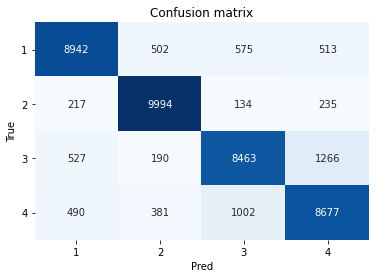

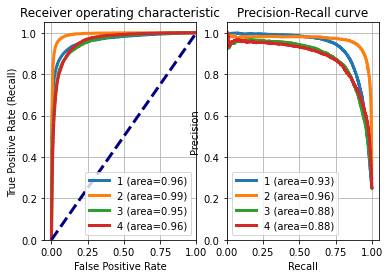

In [18]:
#Logistic Regression algorithm using bag of words classifier
classifier_LR = LogisticRegression(C= 0.1, penalty= 'l2', solver= 'liblinear')
classifier_LR.fit(X_train,y_train)
predicted_LR = classifier_LR.predict(X_test)
predicted_prob_LR = classifier_LR.predict_proba(X_test)

model_evaluation(y_test,predicted_LR,predicted_prob_LR)


In [21]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 250]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sample, y_sample)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.796333 using {'max_features': 'log2', 'n_estimators': 250}
0.721833 (0.021340) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.761333 (0.017885) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.768667 (0.015326) with: {'max_features': 'sqrt', 'n_estimators': 250}
0.729667 (0.022077) with: {'max_features': 'log2', 'n_estimators': 10}
0.784667 (0.018616) with: {'max_features': 'log2', 'n_estimators': 100}
0.796333 (0.017317) with: {'max_features': 'log2', 'n_estimators': 250}


Accuracy: 0.87
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           1       0.88      0.87      0.88     10532
           2       0.90      0.95      0.92     10580
           3       0.85      0.82      0.83     10446
           4       0.83      0.83      0.83     10550

    accuracy                           0.87     42108
   macro avg       0.87      0.87      0.87     42108
weighted avg       0.87      0.87      0.87     42108



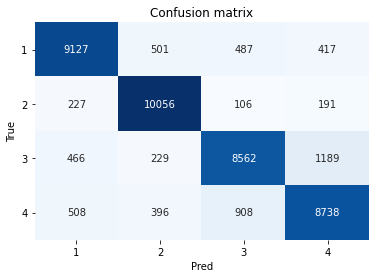

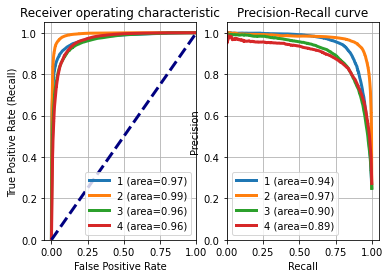

In [21]:
#Grid search to find the optimal parameters
classifier_RF = RandomForestClassifier(max_features = 'log2', n_estimators = 250)
classifier_RF.fit(X_train,y_train)
predicted_RF = classifier_RF.predict(X_test)
predicted_prob_RF = classifier_RF.predict_proba(X_test)

model_evaluation(y_test,predicted_RF,predicted_prob_RF)

In [27]:
#Grid search to find the optimal parameters
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
n_estimators = [10, 100, 500]
learning_rate = [0.01, 0.1, 1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 5, 7]
# define grid search
grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_sample, y_sample)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.780492 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.5}
0.577998 (0.016218) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.5}
0.544999 (0.001599) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'subsample': 0.7}
0.453003 (0.011926) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'subsample': 1.0}
0.688004 (0.014968) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
0.642998 (0.013673) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
0.622013 (0.019460) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
0.759995 (0.008723) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}
0.749998 (0.004050) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
0.735003 (0.003754) with: {'learning_rate': 0.01, 'max_depth': 3

Accuracy: 0.83
Auc: 0.95
Detail:
              precision    recall  f1-score   support

           1       0.85      0.83      0.84       820
           2       0.91      0.91      0.91       810
           3       0.82      0.80      0.81       813
           4       0.77      0.80      0.78       857

    accuracy                           0.83      3300
   macro avg       0.84      0.83      0.84      3300
weighted avg       0.83      0.83      0.83      3300



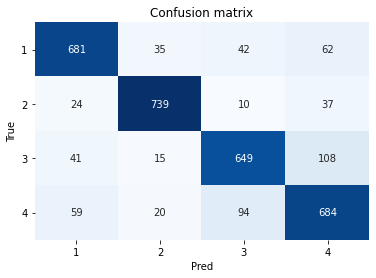

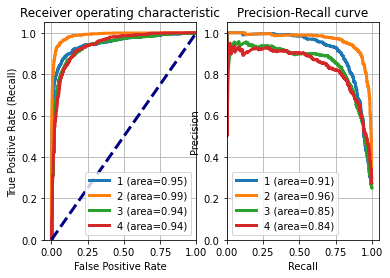

In [21]:
# Naive Bayes using BOW vectorization
classifier_GB = GradientBoostingClassifier(learning_rate =0.1, max_depth =7, n_estimators = 500, subsample= 0.5)
classifier_GB.fit(X_train, y_train)

predicted_GB = classifier_GB.predict(X_test)
predicted_prob_GB = classifier_GB.predict_proba(X_test)

model_evaluation(y_test,predicted_GB,predicted_prob_GB)

# Implementing all the algorithms again using TF-IDF vectorization, to evaluate the classifiers performance in different vectorization methods

In [22]:
##count vectorizer to convert text to feature vectors
vectorizer = TfidfVectorizer()
X_sample = vectorizer.fit_transform(train_sample.iloc[:, -1])


##storing the class label in y 
y_sample = train_sample.iloc[:, 0].astype(str)

##count vectorizer to convert text to feature vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data.iloc[:, -1])


##storing the class label in y 
y = data.iloc[:, 0].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2021)`

Accuracy: 0.91
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           1       0.92      0.90      0.91     10532
           2       0.95      0.98      0.97     10580
           3       0.88      0.88      0.88     10446
           4       0.89      0.89      0.89     10550

    accuracy                           0.91     42108
   macro avg       0.91      0.91      0.91     42108
weighted avg       0.91      0.91      0.91     42108



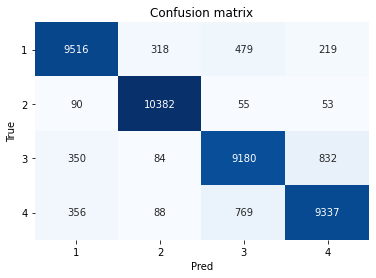

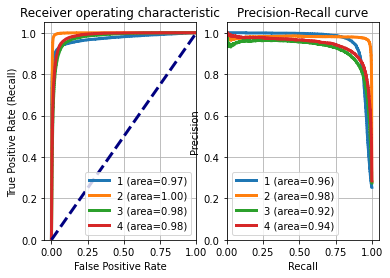

In [23]:
# Naive Bayes using tf-idf vectorization
classifier_NB = MultinomialNB()
classifier_NB.fit(X, y)

predicted_NB = classifier_NB.predict(X_test)
predicted_prob_NB = classifier_NB.predict_proba(X_test)

model_evaluation(y_test,predicted_NB,predicted_prob_NB)

Accuracy: 0.91
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           1       0.92      0.89      0.91     10532
           2       0.95      0.98      0.96     10580
           3       0.87      0.87      0.87     10446
           4       0.88      0.88      0.88     10550

    accuracy                           0.91     42108
   macro avg       0.91      0.91      0.91     42108
weighted avg       0.91      0.91      0.91     42108



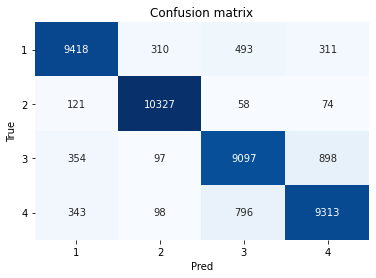

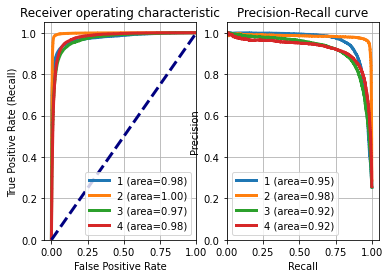

In [24]:
# linear SVC using tf-idf vectorization
classifier_SVC = SVC(C= 1.0, gamma= 'scale', kernel= 'sigmoid')
classifier_SVC = LinearSVC(random_state=2021, tol=1e-5)
classifier_SVC.fit(X_train, y_train)

predicted_SVC = classifier_SVC.predict(X_test)
predicted_prob_SVC = classifier_SVC._predict_proba_lr(X_test)

model_evaluation(y_test,predicted_SVC,predicted_prob_SVC)

Accuracy: 0.88
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           1       0.90      0.88      0.89     10532
           2       0.92      0.97      0.95     10580
           3       0.86      0.83      0.84     10446
           4       0.85      0.85      0.85     10550

    accuracy                           0.88     42108
   macro avg       0.88      0.88      0.88     42108
weighted avg       0.88      0.88      0.88     42108



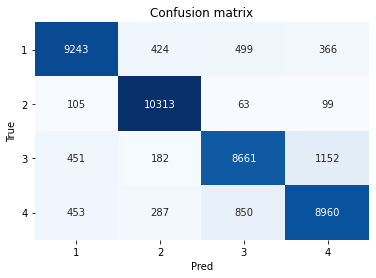

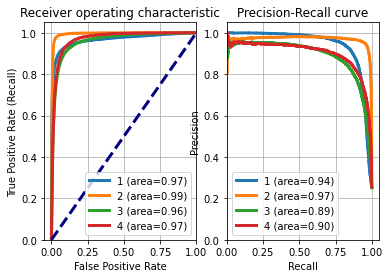

In [25]:
#logistic regression classifier using tf-idf vectorization
classifier_LR = LogisticRegression(C= 0.1, penalty= 'l2', solver= 'liblinear')
classifier_LR.fit(X_train,y_train)
predicted_LR = classifier_LR.predict(X_test)
predicted_prob_LR = classifier_LR.predict_proba(X_test)

model_evaluation(y_test,predicted_LR,predicted_prob_LR)

Accuracy: 0.9
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           1       0.92      0.90      0.91     10532
           2       0.95      0.98      0.97     10580
           3       0.88      0.85      0.87     10446
           4       0.86      0.89      0.87     10550

    accuracy                           0.90     42108
   macro avg       0.90      0.90      0.90     42108
weighted avg       0.90      0.90      0.90     42108



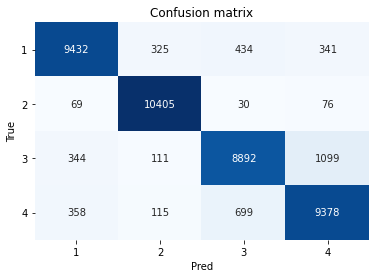

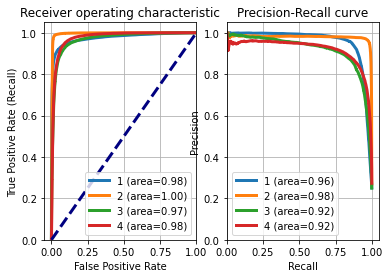

In [26]:
#Random Forest algorithm using tf-idf vectorization 
classifier_RF = RandomForestClassifier(max_features = 'log2', n_estimators = 250)
classifier_RF.fit(X_train,y_train)
predicted_RF = classifier_RF.predict(X_test)
predicted_prob_RF = classifier_RF.predict_proba(X_test)

model_evaluation(y_test,predicted_RF,predicted_prob_RF)

Accuracy: 0.84
Auc: 0.95
Detail:
              precision    recall  f1-score   support

           1       0.86      0.85      0.85       820
           2       0.92      0.94      0.93       810
           3       0.81      0.78      0.80       813
           4       0.79      0.80      0.79       857

    accuracy                           0.84      3300
   macro avg       0.84      0.84      0.84      3300
weighted avg       0.84      0.84      0.84      3300



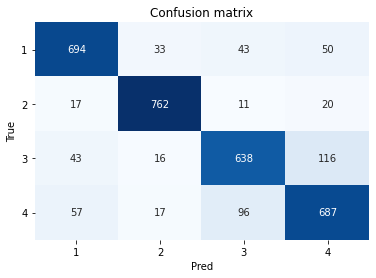

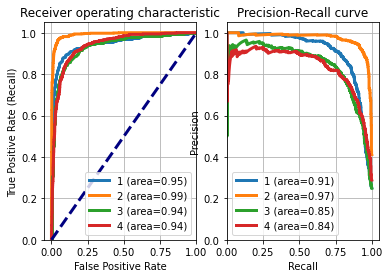

In [23]:
# Naive Bayes using tf-idf vectorization
classifier_GB = GradientBoostingClassifier(learning_rate =0.1, max_depth =7, n_estimators = 500, subsample= 0.5)
classifier_GB.fit(X_train, y_train)

predicted_GB = classifier_GB.predict(X_test)
predicted_prob_GB = classifier_GB.predict_proba(X_test)

model_evaluation(y_test,predicted_GB,predicted_prob_GB)